# Pogona Notebook

In [1]:
from Detector.detector import Detector_v4, Detector_v3
from PIL import Image
import torch
from torchvision import transforms
import Detector.visualize as visualize  # TODO check imports
import re
import glob
import os
import numpy as np
import imp
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

In [3]:
detector = Detector_v4()

Detector initiated successfully


In [3]:
detector.set_conf_and_nms(new_conf_thres=0.01)

## Save prediction video

In [4]:
NUM_FRAMES = 1500
test_video_path = "./Arena/output/20200617-222733/19506481.avi"
d = visualize.save_pred_video(test_video_path, 
                              "labelled/1706_222733_dots.mp4", 
                              detector,num_frames=NUM_FRAMES, 
                              visAngle=True,
                              dots=True,
                              arrowWindow=240)

  0%|          | 3/1500 [00:00<01:07, 22.30it/s]

saving to:  labelled/1706_222733_dots.mp4
width: 1440, height: 1080


100%|██████████| 1500/1500 [01:01<00:00, 24.23it/s]

Read: 4.80 ms
Rsz_inf: 28.39 ms
Write: 6.94 ms


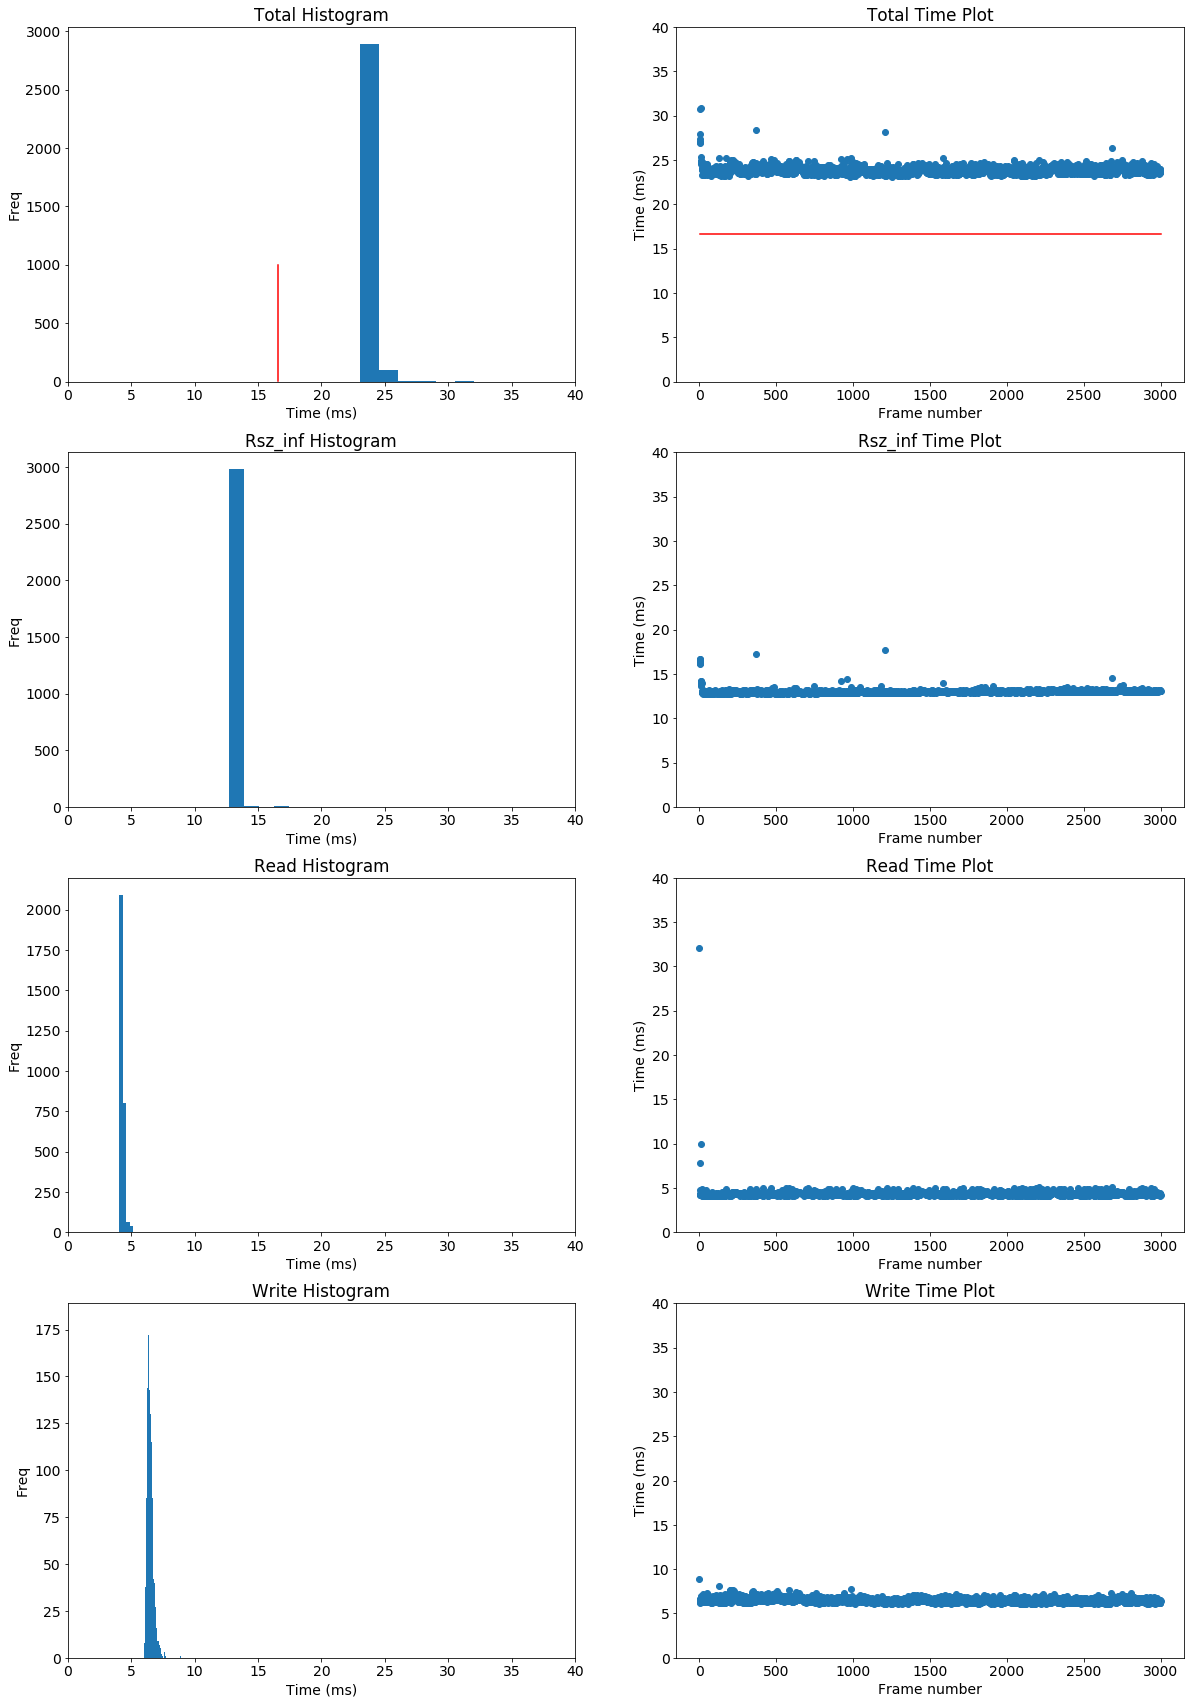

In [13]:
# analyzq timings

XLIM=40
YLIM=40

TOTAL_XLIM = 80
TOTAL_YLIM = 80

times = d[0]
centros = d[1][:,:2]
speed = visualize.compute_velocity(centros)

confs = d[1][:,2]
for k in times.keys():
    print(k,": ",round(1/times[k].mean()))
times['Total'] = np.sum(np.stack([times[k] for k in times.keys() if k!='Total'],axis=1),axis=1)
print("Average FPS: ",round(1/times['Total'].mean()))



phases = ['Rsz_inf','Read','Write'] # sorted order
fig,axs = plt.subplots(len(phases)+1,2,figsize=(20,30))
k='Total'
axs[0][0].set_title(k+' Histogram')
axs[0][1].set_title(k+' Time Plot')
axs[0][0].hist(times[k]*1000,label=k,bins=100)
axs[0][0].set_xlim(0,XLIM)
axs[0][0].set_xlabel('Time (ms)')
axs[0][1].set_xlabel('Frame number')
axs[0][0].set_ylabel('Freq')
axs[0][1].set_ylabel('Time (ms)')
axs[0][1].scatter(np.arange(times[k].shape[0]),times[k]*1000)
axs[0][1].set_ylim(0,YLIM)
axs[0][0].plot(np.ones(5)*16.6,np.linspace(1,1000,5),color='r')
axs[0][1].plot(np.linspace(1,3000,5),np.ones(5)*16.6,color='r')
for i,k in enumerate(phases):
    i+=1
    axs[i][0].set_title(k+' Histogram')
    axs[i][1].set_title(k+' Time Plot')
    axs[i][0].hist(times[k]*1000,label=k,bins=100)
    axs[i][0].set_xlim(0,XLIM)
    axs[i][0].set_xlabel('Time (ms)')
    axs[i][1].set_xlabel('Frame number')
    axs[i][0].set_ylabel('Freq')
    axs[i][1].set_ylabel('Time (ms)')
    axs[i][1].scatter(np.arange(times[k].shape[0]),times[k]*1000)
    axs[i][1].set_ylim(0,YLIM)
#plt.savefig('timings.jpg')

## Plot with figure on video with centroids

In [60]:
%matplotlib agg
imp.reload(visualize)
test_video_path = "./Arena/output/20200615-175044/19506481.avi"
visualize.plot_with_figure(input_name=test_video_path,
                           output_name='labelled/1506_175044_fig_over_subs.mp4',
                           centroids=cents_17,
                           num_frames=3000)

  0%|          | 3/3000 [00:00<02:40, 18.67it/s]

width: 1440, height: 1080


100%|██████████| 3000/3000 [04:53<00:00, 10.23it/s]


## Save missed frames

In [3]:
test_video_path = "/media/sil2/regev/pose_estimation/Arena/output/20200521-195335/19506481-0000.avi"
vid_name = '19506481-0000.avi'
path_to = '/media/sil2/regev/pose_estimation/Arena/output/20200521'
L = glob.glob(path_to+'*')
video_paths = []
output_paths = []
for file in L:
    vid_time = re.search('20200521-(\d+)',file).group(1)
    p = os.path.join(path_to+'-'+vid_time,vid_name)
    if os.path.exists(p):
        video_paths.append(p)
        output_paths.append("labelled/arrow_" + vid_time + ".mp4")
        
video_paths

['/media/sil2/regev/pose_estimation/Arena/output/20200521-172245/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172519/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172637/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-172842/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173206/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173410/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-173606/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174011/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174247/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-174430/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-175816/19506481-0000.avi',
 '/media/sil2/regev/pose_estimation/Arena/output/20200521-180046/

In [30]:
for i in range(len(video_paths)):
    if re.search('20200521-(\d+)',video_paths[i]).group(1)[:2]=='17':
        continue
    inf_time = visualize.save_pred_video(video_paths[i], video_paths[i], detector)
    #print("Inference framerate:", 1/inf_time)

NameError: name 'video_paths' is not defined

In [196]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_Pursuit/Detector/visualize.py'>

In [197]:
input_dir = './Arena/output/20200617-'
time = '222733'
vid_path = input_dir+time+'/19506481.avi'
if os.path.exists(vid_path):
    visualize.save_missed_frames(video_path=vid_path,
                       output_dir='./new_frames_1806_high/',
                       detector=detector,
                       save_thresh=0.98,
                       num_frames=3000,
                       save_max=250,
                       above=True)

  0%|          | 4/3000 [00:00<01:27, 34.17it/s]

saving to:  ./new_frames_1806_high/


  8%|▊         | 240/3000 [00:04<00:53, 51.39it/s]


KeyboardInterrupt: 

## Abaltion study (sort of)

In [304]:
imp.reload(visualize)

<module 'Detector.visualize' from '/app/Pogona_Pursuit/Detector/visualize.py'>

In [162]:
im_good = cv.imread('test_images/test_high.jpg')
im_none = cv.imread('test_images/test_none.jpg')
im_low = cv.imread('test_images/test_low3.jpg')

In [320]:
im = im_none

Possible stride sizes are [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 15, 18, 20, 24, 30, 36, 40, 45, 60, 72, 90, 120, 180, 360]
Please choose stride from the list:


 120


strides x: 12, strides y: 9, total of 108 iterations. Continue [y/n]?


 y


Rows: 100%|██████████| 17/17 [00:09<00:00,  1.82it/s]


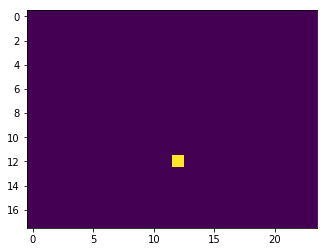

In [323]:
conf_map = visualize.ablation_heatmap(im,detector,255)
plt.imshow(conf_map)

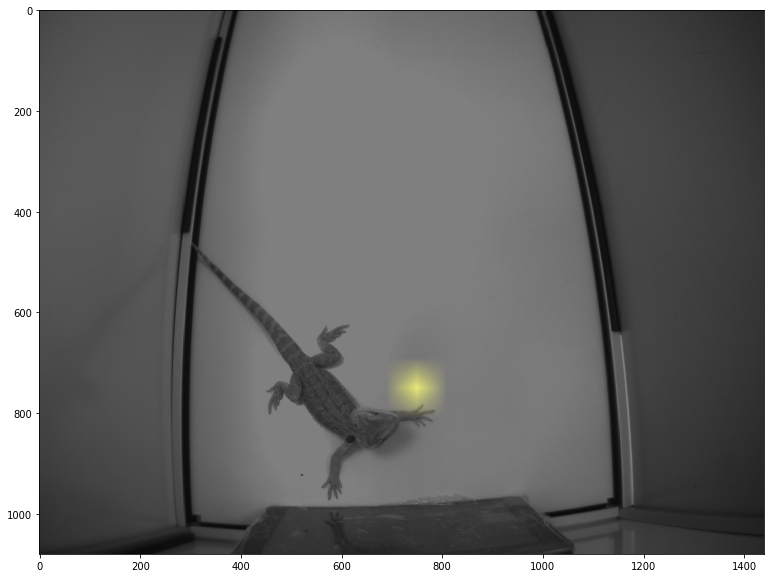

In [324]:
conf_res = cv.resize(conf_map,(1440,1080))
conf_res3 = cv.merge((conf_res,conf_res,np.zeros(conf_res.shape)))
plt.figure(figsize=(19,10))

plt.imshow((0.5*im).astype('uint8') + (0.5*(256*(conf_res3))).astype('uint8'))

In [32]:
conf_res3 = cv.merge(conf_res,conf_res,(np.zeros(conf_res.shape)))

In [274]:
kern = 1-gkern(5,1)

In [272]:
kern.shape

(5, 5, 3)

In [275]:
kern[:,:,2]

array([[0.46821673, 0.32611706, 0.27076528, 0.32611706, 0.46821673],
       [0.32611706, 0.14604644, 0.07590392, 0.14604644, 0.32611706],
       [0.27076528, 0.07590392, 0.        , 0.07590392, 0.27076528],
       [0.32611706, 0.14604644, 0.07590392, 0.14604644, 0.32611706],
       [0.46821673, 0.32611706, 0.27076528, 0.32611706, 0.46821673]])

In [157]:
x = input()

In [160]:
x is ''


True